# Auxiliary functions

In [193]:
import numpy as np
from functools import reduce
from matplotlib import pyplot as plt

sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
time_axis = np.linspace(0, 20, 2000)

def generate_hamiltonian(
        tunneling_strength: float = 0,
        particle_interaction: float = 0,
        energy_shift: float = 0
) -> np.array:
    return reduce(np.add, [
        tunneling_strength * sigma_z,
        particle_interaction * (sigma_z @ sigma_z),
        energy_shift * sigma_x
    ])


def partial_trace(temp_rho: np.array, dimensions: (int, int, int, int)) -> np.array:
    return np.einsum('ikjk->ij', temp_rho.reshape(*dimensions))


def calculate_probabilities(rho: np.array) -> np.array:
    return np.vectorize(np.abs)([
        rho[:, t, t]
        for t in range(rho.shape[1])
    ])

def plot_probabilities(explicit_rho) -> None:
    labels = range(explicit_rho.shape[1])

    plt.figure(figsize=(20, 3))
    plt.stackplot(
        time_axis,
        calculate_probabilities(explicit_rho),
        baseline="zero",
        labels=labels,
    )
    plt.legend()


# Parameters

# Define the Hamiltonian

In [194]:
system_hamiltonian = generate_hamiltonian(tunneling_strength=.1, particle_interaction=.2, energy_shift=.3)
ancillary_hamiltonian = generate_hamiltonian(tunneling_strength=.1, particle_interaction=.4, energy_shift=.5)
non_interactive_hamiltonian = np.kron(system_hamiltonian, ancillary_hamiltonian)
non_interactive_hamiltonian  # Rows represent ( 00, 01, 10, 11 )

array([[0.15, 0.15, 0.15, 0.15],
       [0.15, 0.09, 0.15, 0.09],
       [0.15, 0.15, 0.05, 0.05],
       [0.15, 0.09, 0.05, 0.03]])

In [195]:
alpha = .05
alpha * np.kron(sigma_x, sigma_z)

array([[ 0.  ,  0.  ,  0.05,  0.  ],
       [ 0.  ,  0.  ,  0.  , -0.05],
       [ 0.05,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.05,  0.  ,  0.  ]])

In [196]:
full_hamiltonian = np.add(
    non_interactive_hamiltonian,
    alpha * np.kron(sigma_x, sigma_z)
)
full_hamiltonian

array([[0.15, 0.15, 0.2 , 0.15],
       [0.15, 0.09, 0.15, 0.04],
       [0.2 , 0.15, 0.05, 0.05],
       [0.15, 0.04, 0.05, 0.03]])

# Initialize density matrix

In [197]:
# interaction term
x = .8
a = .1 + .1j

rhoA = np.array([[x, a], [np.conj(a), 1 - x]])
rho0 = np.kron([[1, 0], [0, 0]], rhoA)
rho0

# Checks
assert (np.conj(rho0).T == rho0).all(), "rho0 is not hermitian"
assert np.einsum('ii->', rho0) ==1, "The trace of rho0 is not 1"
assert np.linalg.det(rhoA)>0, "rhoA is not semi-positive"

# Time evolution

In [198]:
from scipy.linalg import expm

full_rho = lambda t: expm(-1j * full_hamiltonian * t) @ rho0 @ expm(1j * full_hamiltonian * t)

# Reduced rho

In [199]:
explicit_rho = np.array([full_rho(t) for t in time_axis])  # Indexed as (time, state_i, state_j)
reduced_rho = np.array([
    np.einsum('ikjk->ij', rhot.reshape(2, 2, 2, 2))  # TODO: the dimensions should be inferred
    for rhot in explicit_rho
])

# Visualization

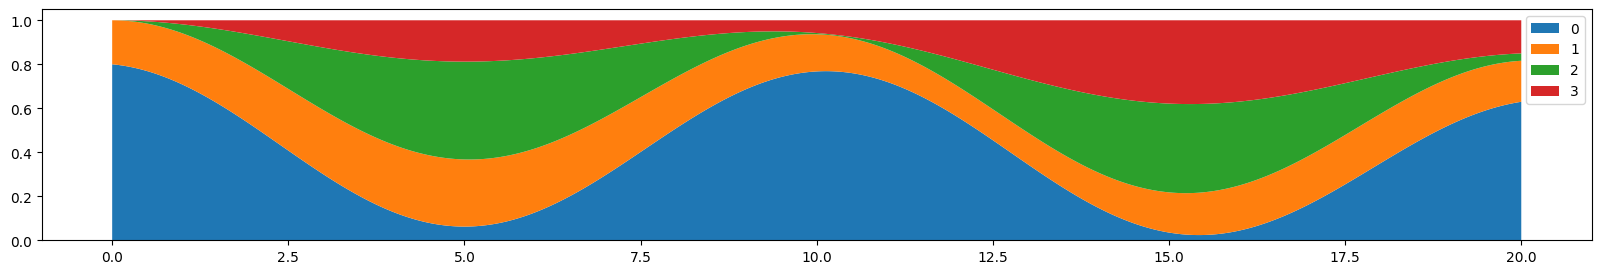

In [200]:
plot_probabilities(explicit_rho=explicit_rho)

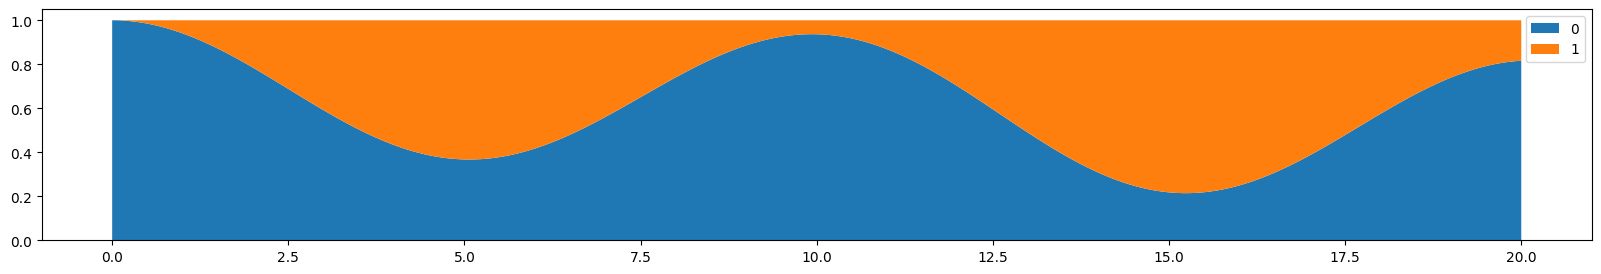

In [201]:
plot_probabilities(explicit_rho=reduced_rho)